### 데이터 준비 및 환경 설정

In [1]:
import os
import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("../../데이터/주가데이터"):
    sp_data = pd.read_csv("../../데이터/주가데이터/" + file_name,
                          parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

### 모멘텀

#### 분석용 데이터 생성

In [4]:
import numpy as np
mom_data = pd.DataFrame()
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    sp = sp_data["Close"].values
    
    # 모멘텀 계산
    mom_5 = (sp[5:] - sp[:-5]) / sp[:-5] * 100
    mom_10 = (sp[10:] - sp[:-10]) / sp[:-10] * 100
    mom_20 = (sp[20:] - sp[:-20]) / sp[:-20] * 100
    mom_5 = np.insert(mom_5, [0] * 5, np.nan)
    mom_10 = np.insert(mom_10, [0] * 10, np.nan)
    mom_20 = np.insert(mom_20, [0] * 20, np.nan)
    
    # 모멘텀 변수 추가
    temp = pd.DataFrame({"Date":sp_data['Date'].values})
    temp["모멘텀_5"] = mom_5
    temp["모멘텀_10"] = mom_10
    temp["모멘텀_20"] = mom_20
    
    # 수익률 추가 
    ror_5 = np.insert(mom_5, [-1] * 5, np.nan)[5:]
    ror_10 = np.insert(mom_10, [-1] * 10, np.nan)[10:]
    ror_20 = np.insert(mom_20, [-1] * 20, np.nan)[20:]
    temp["수익률_5"] = ror_5
    temp["수익률_10"] = ror_10
    temp["수익률_20"] = ror_20
    
    temp.dropna(inplace = True)
    mom_data = pd.concat([mom_data, temp], axis = 0, ignore_index = True)

#### 동일 가중 교체 매매 구현

In [5]:
result = []
date_list = sorted(mom_data["Date"].unique())
for date in date_list:
    temp = mom_data.loc[mom_data['Date'] == date]
    for n in [5, 10, 20]:
        temp["그룹"] = pd.qcut(temp['모멘텀_' + str(n)], 5,
                               labels = range(5)).astype(int)
        for group in range(5):
            ror_list = temp.loc[temp["그룹"] == group, "수익률_" + str(n)].values
            inve_per_stock = 10 ** 8 / sum(temp["그룹"] == group)
            profit = (inve_per_stock * ror_list / 100).sum()
            profit_ratio = profit / 10 ** 8 * 100
            result.append([n, group, profit_ratio])

result = pd.DataFrame(result, columns = ["영업일", "그룹", "수익률"])

#### 결과 확인 및 시각화

<AxesSubplot:xlabel='영업일,그룹'>

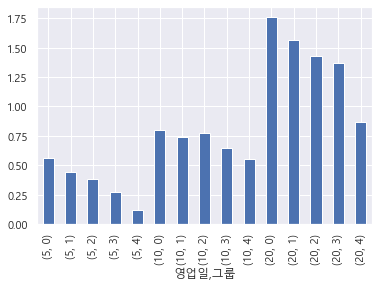

In [6]:
result.groupby(['영업일', '그룹'])['수익률'].mean().round(2).plot(kind = 'bar')

<AxesSubplot:xlabel='영업일,그룹'>

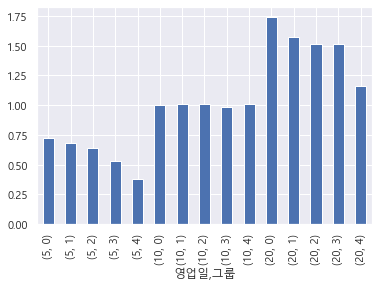

In [7]:
result.groupby(['영업일', '그룹'])['수익률'].median().round(2).plot(kind = 'bar')

In [8]:
display(result.groupby(['영업일', '그룹'])['수익률'].describe().round(2))

count  mean   std    min   25%   50%   75%    max
영업일 그룹                                                    
5   0   2608.0  0.56  3.73 -33.53 -1.20  0.72  2.42  35.95
    1   2608.0  0.44  3.21 -30.04 -0.95  0.68  1.99  29.16
    2   2608.0  0.38  2.90 -29.17 -0.88  0.64  1.86  24.47
    3   2608.0  0.27  2.73 -24.72 -0.89  0.53  1.76  19.87
    4   2608.0  0.12  2.83 -20.75 -1.30  0.38  1.84  13.96
10  0   2608.0  0.80  5.27 -42.25 -1.94  1.00  3.51  58.22
    1   2608.0  0.74  4.52 -41.11 -1.47  1.01  2.99  46.68
    2   2608.0  0.77  4.12 -37.60 -1.22  1.01  2.96  39.06
    3   2608.0  0.65  3.83 -32.39 -1.25  0.98  2.87  29.19
    4   2608.0  0.55  4.00 -27.43 -1.72  1.01  3.09  18.95
20  0   2608.0  1.76  7.37 -42.81 -2.29  1.74  5.70  78.52
    1   2608.0  1.56  6.41 -39.58 -1.73  1.57  5.04  65.09
    2   2608.0  1.43  5.83 -38.99 -1.51  1.51  4.54  52.69
    3   2608.0  1.37  5.43 -33.73 -1.43  1.51  4.47  43.19
    4   2608.0  0.87  5.84 -40.90 -2.66  1.16  4.54  23.26

### 방향성 지수

#### 분석용 데이터 생성

In [9]:
dmi_data_dict = dict()
for stock_name in sp_data_dict.keys():
    # 데이터 정의
    sp_data = sp_data_dict[stock_name]
    high_price = sp_data["High"].values
    low_price = sp_data["Low"].values
    close_price = sp_data["Close"].values
    
    # 당일과 전일의 고가, 저가, 종가 정의
    cur_high_price = high_price[1:]
    pre_high_price = high_price[:-1]
    cur_low_price = low_price[1:]
    pre_low_price = low_price[:-1]
    cur_close_price = close_price[1:]
    pre_close_price = close_price[:-1]
    
    # PDM과 MDM 계산
    PDM = cur_high_price - pre_high_price
    PDM[PDM < 0] = 0
    MDM = cur_low_price - pre_low_price
    MDM[MDM < 0] = 0
    
    # TR 계산
    TR1 = np.abs(cur_high_price - cur_low_price)
    TR2 = np.abs(cur_high_price - pre_close_price)
    TR3 = np.abs(cur_low_price - pre_close_price)
    TR = np.vstack([TR1, TR2, TR3]).max(axis = 0)
    
    dmi_data = pd.DataFrame({"Close":close_price})    
    dmi_data.drop(0, inplace = True)
    dmi_data["PDM"] = PDM
    dmi_data["MDM"] = MDM
    dmi_data["TR"] = TR
    for n in [5, 10, 20]:
        PDM_n = dmi_data["PDM"].rolling(n).mean()
        MDM_n = dmi_data["MDM"].rolling(n).mean()
        TR_n = dmi_data["TR"].rolling(n).mean()
        PDI_n = PDM_n / TR_n
        MDI_n = MDM_n / TR_n
        DX_n = (PDI_n - MDI_n) / (PDI_n + MDI_n) * 100
        ADX_n = DX_n.rolling(n).mean()
        
        dmi_data["PDI_" + str(n)] = PDI_n
        dmi_data["MDI_" + str(n)] = MDI_n
        dmi_data["ADX_" + str(n)] = ADX_n
    
    dmi_data.drop(['PDM', 'MDM', 'TR'], axis = 1, inplace = True)
    dmi_data_dict[stock_name] = dmi_data

#### PDI와 MDI만 활용한 매매 전략 검증

In [10]:
result_dict = {5:[], 10:[], 20:[]}
for stock_name in dmi_data_dict.keys():
    dmi_data = dmi_data_dict[stock_name]
    for n in [5, 10, 20]:
        PDI = dmi_data["PDI_" + str(n)].values
        MDI = dmi_data["MDI_" + str(n)].values
        # 매수 시점 목록 정의
        bp_list = (PDI[1:] > MDI[1:]) & (PDI[:-1] <= MDI[:-1])
        bp_list = np.insert(bp_list, 0, False)
        bp_list = dmi_data.index[bp_list]
        # 매도 시점 목록 정의
        sp_list = (PDI[1:] < MDI[1:]) & (PDI[:-1] > MDI[:-1])
        sp_list = np.insert(sp_list, 0, False)
        sp_list = dmi_data.index[sp_list]

        for bp in bp_list:
            if (sum(bp<sp_list) > 0) and (bp + 1 <= dmi_data.index[-1]):
                buy_price = dmi_data.loc[bp + 1, "Close"]
                sp = sp_list[sp_list > bp][0] + 1
                if sp <= dmi_data.index[-1]:
                    sell_price = dmi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    result_dict[n].append(profit)
            else:
                break

In [11]:
result = pd.DataFrame()
for n in [5, 10, 20]:
    result = pd.concat([result, pd.Series(result_dict[n]).describe()], axis = 1)
result.columns = [5, 10, 20]
display(result)

,5,10,20
count,575915.000000,396316.000000,256315.000000
mean,0.308006,0.499711,0.780359
std,8.587826,11.102165,15.767842
min,-91.598630,-92.033184,-92.322886
25%,-2.681626,-2.957486,-3.215926
50%,-0.162075,-0.195312,-0.242601
75%,2.286585,2.443609,2.473498
max,584.235774,1211.111111,2258.490566


#### PDI, MDI, ADX를 활용한 매매 전략 검증

In [12]:
result_dict = {5:[], 10:[], 20:[]}
for stock_name in dmi_data_dict.keys():
    dmi_data = dmi_data_dict[stock_name]
    for n in [5, 10, 20]:
        PDI = dmi_data["PDI_" + str(n)].values
        MDI = dmi_data["MDI_" + str(n)].values
        ADX = dmi_data["ADX_" + str(n)].values

        bp_list = ((PDI[1:] > MDI[1:]) & (ADX[1:] >= 25)) 
        bp_list &= ((PDI[:-1] <= MDI[:-1]) | (ADX[:-1] < 25))
        bp_list = np.insert(bp_list, 0, False)
        bp_list = dmi_data.index[bp_list] 

        sp_list = ((PDI[1:] <= MDI[1:]) & (ADX[1:] >= 25)) 
        sp_list &= ((PDI[:-1] > MDI[:-1]) | (ADX[:-1] < 25))
        sp_list = np.insert(sp_list, 0, False)
        sp_list = dmi_data.index[sp_list] 

        for bp in bp_list:
            if (sum(bp < sp_list) > 0) and (bp + 1 <= dmi_data.index[-1]):
                buy_price = dmi_data.loc[bp + 1, "Close"]
                sp = sp_list[sp_list > bp][0] + 1
                if sp <= dmi_data.index[-1]:
                    sell_price = dmi_data.loc[sp, "Close"]
                    profit = (sell_price - buy_price) / buy_price * 100
                    result_dict[n].append(profit)
            else:
                break

In [13]:
result = pd.DataFrame()
for n in [5, 10, 20]:
    result = pd.concat([result, pd.Series(result_dict[n]).describe()], axis = 1)
result.columns = [5, 10, 20]
display(result)

,5,10,20
count,198441.000000,72695.000000,22459.000000
mean,3.207153,5.023546,7.530121
std,34.848413,45.550595,65.457218
min,-98.893099,-97.829648,-99.105313
25%,-7.100592,-9.027778,-12.370497
50%,-0.623441,-1.037613,-1.694915
75%,4.977376,5.637255,7.019860
max,2518.985696,1309.395973,2669.335938


### 엔빌롭

#### 데이터 준비

In [14]:
env_data_dict = dict()
for stock_name in sp_data_dict.keys():
    # 데이터 정의
    sp_data = sp_data_dict[stock_name]
    env_data = sp_data.copy() # sp_data 복제
    low_price = env_data["Low"].values
    high_price = env_data["High"].values
    for n in [5, 10, 20]:
        env_data["MA_" + str(n)] = env_data["Close"].rolling(n).mean()
        for a in [0.05, 0.1, 0.15, 0.2]:
            env_data["지지선_{}_{}".format(n, a)] = env_data["MA_" + str(n)] * (1-a)
            env_data["저항선_{}_{}".format(n, a)] = env_data["MA_" + str(n)] * (1+a)
    env_data_dict[stock_name] = env_data

#### 전략 검증 및 시각화

In [15]:
mean_result = []
median_result = []
for n in [5, 10, 20]:
    for a in [0.05, 0.1, 0.15, 0.2]:
        ror_list = []
        for stock_name in env_data_dict.keys():
            env_data = env_data_dict[stock_name]
            low_price = env_data["Low"].values
            high_price = env_data["High"].values
            res = env_data["저항선_{}_{}".format(n, a)].values
            sup = env_data["지지선_{}_{}".format(n, a)].values
            
            bp_list = (low_price[1:] <= sup[1:]) & (low_price[:-1] > sup[:-1])
            bp_list = np.insert(bp_list, 0, False)
            bp_list = env_data.index[bp_list] 
            
            sp_list = (high_price[1:] >= res[1:]) & (high_price[:-1] < res[:-1])
            sp_list = np.insert(sp_list, 0, False)
            sp_list = env_data.index[sp_list]
            
            for bp in bp_list:
                if (sum(bp < sp_list) > 0) and (bp + 1 <= env_data.index[-1]):
                    buy_price = env_data.loc[bp + 1, "Close"]
                    sp = sp_list[sp_list > bp][0] + 1
                    if sp <= env_data.index[-1]:
                        sell_price = env_data.loc[sp, "Close"]
                        ror = (sell_price - buy_price) / buy_price * 100
                        ror_list.append(ror)
                else:
                    break

        mean_result.append(np.mean(ror_list))
        median_result.append(np.quantile(ror_list, 0.5))
    
mean_result = np.array(mean_result).reshape(3, 4)
median_result = np.array(median_result).reshape(3, 4)

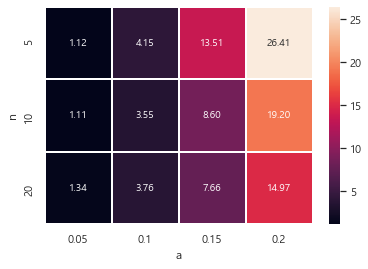

In [16]:
sns.heatmap(mean_result, annot = True, fmt = ".2f", linewidth = 1)
plt.yticks([0.5, 1.5, 2.5], [5, 10, 20])
plt.xticks([0.5, 1.5, 2.5, 3.5], [0.05, 0.1, 0.15, 0.2])
plt.ylabel("n")
plt.xlabel("a")
plt.show()

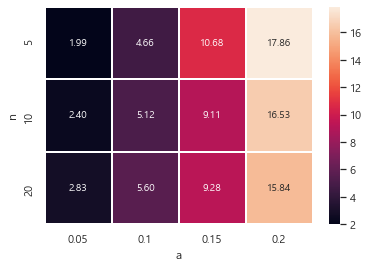

In [17]:
sns.heatmap(median_result, annot = True, fmt = ".2f", linewidth = 1)
plt.yticks([0.5, 1.5, 2.5], [5, 10, 20])
plt.xticks([0.5, 1.5, 2.5, 3.5], [0.05, 0.1, 0.15, 0.2])
plt.ylabel("n")
plt.xlabel("a")
plt.show()